## Introduction

The increasing frequency and intensity of cyclonic rainfall events pose significant threats to insurance markets in climate-vulnerable coastal regions. In Phase 2 of the World Bank Climate Risk Challenge, our team *DelphiQ* presents a working prototype that integrates **quantum-enhanced risk forecasting** and **portfolio optimization** to address such challenges in coastal New Zealand.

We focus on **risk prediction** and **risk diversification**, developing a hybrid framework that leverages:

- A **Quantum Reuploading Unit (QRU)** for time-series rainfall forecasting,
- A **QAOA-based Conditional Value-at-Risk optimizer** for regional insurance allocation,
- A **smart parametric payout logic** for inclusive, fast-response insurance.

This notebook outlines our **technical implementation**, simulation results, data-driven insights, and real-world stakeholder impact. It is designed as a proof-of-concept combining quantum innovation with scalable climate resilience.

---

## 👥 Team DelphiQ

- **Jacinta May** – *Quantum Theorist & Lead* (BSc, Univ. of Sydney)  
  Co-founder of Pikkl. Expertise: Quantum hardware, environmental chemistry.

- **Sabarikirishwaran Ponnambalam** – *Quantum Algorithms* (PhD, Griffith University)  
  Specialist in QAOA, Variational Circuits, Quantum Optimization.

- **Léa Cassé** – *Quantum Machine Learning & Environmental Data* (PhD, Univ. of Waikato / École Polytechnique)  
  Expertise: QRU-based models, forecasting, TAIAO project collaborator.

- **Nicolas De Matteis** – *Business Lead* (BEng, UNSW)  
  Commercialization of quantum tech, environmental business ventures.


## Phase 2: Prototype Development & Technical Foundation

### 1. Focus Area and Use Case

#### 1.1 Problem Background

The increasing frequency and intensity of climate-induced extreme events, particularly cyclone-induced flooding, is putting pressure on the insurability of assets in vulnerable regions like coastal New Zealand. Insurance gaps are widening for underserved populations due to insufficient risk modeling and reactive pricing models.

#### 1.2 Chosen Focus Areas

* **Risk Assessment and Prediction**
* **Risk Diversification**
* **Dynamic Pricing**

#### 1.3 Rationale

These areas align with our team’s expertise in quantum ML and optimization. By enhancing forecasting accuracy and enabling proactive premium adjustment, we aim to prevent insurance market withdrawal in high-risk zones.

---

### 2. Quantum-Driven Solution Design

#### 2.1 Overview of the Hybrid Architecture

Our system integrates classical environmental datasets with quantum models in a hybrid workflow:

* **QRU** for rainfall-based flooding prediction
* **QAOA** for optimal risk portfolio balancing
* **Quantum Generative Model** for pricing scenarios
* **Classical Backend** for data preprocessing, insurance logic, and payout triggers

#### 2.2 QRU for Risk Prediction

* Custom single-qubit **Quantum Reuploading Unit (QRU)** using Pennylane
* Trained on TAIAO rainfall and river-level data
* Forecasts 24-hour rainfall exceedance for flood risk triggers

#### 2.3 QAOA for Risk Diversification

* Define CVaR-based QUBO for premium allocation
* Solve with `openqaoa` or IBM QAOA solvers
* Dynamic adjustment of weights across geographic zones

#### 2.4 Parametric Pricing and Payout System

* Use generative model for synthetic scenario simulation
* Implement auto-triggered payouts if rainfall > threshold (e.g., 150mm in 24h)
* Leverage payout logic for real-time relief

---

### 3. Data Modeling and Simulation

#### 3.1 Data Sources

* TAIAO MetOcean hourly rainfall and wind speed data
* River-level observations from regional councils (Auckland, Waikato, Coromandel)
* Climate insurance product structures

#### 3.2 Preprocessing

* Skip metadata rows, unify column naming (datetime, rainfall\_mm, wind\_speed\_kph)
* Normalize input features, generate supervised datasets via sliding window (24h lookback)

#### 3.3 Simulation Outputs

* QRU prediction accuracy vs Monte Carlo baseline
* QAOA risk allocation heatmaps
* Payout activation frequencies

---

### 4. Quantum Platform & Resource Planning

#### 4.1 Selected Platforms

* **QRU**: Pennylane + `lightning.qubit` on NVIDIA GPUs (local & qBraid)
* **QAOA**: IBM QAOA simulator, with fallback to `openqaoa`
* **Generative Model**: CuQuantum + Qiskit GPU backend (for synthesis)

#### 4.2 Circuit Requirements

* QRU: 1-3 qubits, 40-60 circuit depth, 2000 shots
* QAOA: 4-8 qubits, depth \~50, depending on asset zones
* Integrated with PyTorch, Pandas, and Matplotlib for hybrid orchestration

---

### 5. Stakeholder Impact

#### 5.1 Beneficiaries

* **Insurers & Reinsurers**: Better pricing, lower capital reserve
* **Governments**: Early warning + disaster relief targeting
* **Low-income populations**: Access to microinsurance products

#### 5.2 Impact

* Increases coverage reliability
* Enables fair pricing in volatile zones
* Shortens recovery time after climate shocks

---

### 6. References

* Nikolaos Schetakis et al. (2025). Quantum Reuploading Networks. arXiv:2501.12776
* Vishal Sharma et al. (2022). OpenQAOA: Quantum Optimization Toolkit. arXiv:2210.08695
* Mashiyat Zaman et al. (2021). pyqubo: QUBO Modeling Framework. IEEE Transactions on Computers


### 🌧️ Auckland Region – Eligible Rivers for Climate Risk Study

Rivers either within Auckland or under its greater hydrological influence (e.g., Franklin, Hauraki Plains, Coromandel). All are **≥ 50 km** in length and **≥ 2 m** in depth.

---

- **Marokopa River – Falls [Selected for this Study]** 
  • Depth: 2.25 m  
  • Region: Waikato / Auckland border  
  • Length: ~58 km  

- **Oraka Stream – Pinedale [Selected for this Study]** 
  • Depth: 2.01 m  
  • Region: Northern Waikato (Auckland catchment)  
  • Length: ~50+ km (assumed)

- **Waikato River (multiple sites)** TRUE (hamilton)  
  • Depths: 6.72 – 11.69 m  
  • Region: Hamilton → Auckland supply  
  • Length: 425 km  

- **Waipa River (Otewa, SH23, SH31)**  
  • Depths: 9.02 – 28.30 m  
  • Region: Waikato  
  • Length: 115 km  

- **Waihou River (Okauia, Te Aroha)**  
  • Depths: 2.38 – 7.35 m  
  • Region: Hauraki / Coromandel  
  • Length: ~150 km  

- **Ohinemuri River (Karangahake, Queens Head)**  
  • Depths: 2.80 – 5.84 m  
  • Region: Coromandel / Hauraki  
  • Length: ~70 km  

## Data Loading -> PreProcessing --> Visualization

In [53]:
import os
import gzip
import io
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# -------- Module 1: Data Acquisition & Preprocessing (with River Integration) -------- #

def load_weather_data(folder_path='.', datetime_format='%d-%b-%Y %H:%M'):
    """
    Load all .csv.gz weather files (rainfall/wind) in folder_path.
    - Skip initial blank or metadata lines by detecting the header row.
    - Parse and unify 'datetime', 'rainfall_mm', 'wind_speed_mps'.
    """    
    # Keywords expected in header to identify the right row
    expected_keywords = ['date', 'time', 'rain', 'wind']
    
    for file in glob(os.path.join(folder_path, '*.csv.gz')):
        name = os.path.basename(file).replace('.csv.gz', '')
        try:
            # Read raw lines
            with gzip.open(file, 'rt') as f:
                lines = f.readlines()
                
            # Detect header index: first line containing all expected keywords
            header_idx = 0
            for idx, line in enumerate(lines):
                tokens = set(line.strip().lower().split(" "))                
                if any(keyword in tokens for keyword in expected_keywords):
                    header_idx = idx
                    break
                            
            # Load DataFrame from header row onward
            df = pd.read_csv(
                io.StringIO(''.join(lines[header_idx:])),
                dtype=str,
                low_memory=False
            )
            
            # Parse datetime (combining 'date' and 'time' if separate)
            if 'date' in df.columns and 'time' in df.columns:
                df['datetime'] = pd.to_datetime(
                    df['date'] + ' ' + df['time'],
                    format=datetime_format,
                    errors='coerce'
                )
                df.drop(columns=['date', 'time'], inplace=True)                
            else:
                # fallback: single datetime column
                dt_col = next((col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()), None) 
                df['datetime'] = pd.to_datetime(df[dt_col], format=datetime_format, errors='coerce')                
                df.drop(columns=[dt_col], inplace=True)
            
            # Rename rainfall and wind columns
            rename_map = {}
            for c in df.columns:
                lc = c.lower()
                if 'rain' in lc: 
                    rename_map[c] = 'rainfall_mm'
                if 'wind' in lc and 'speed' in lc:
                    rename_map[c] = 'wind_speed_mps'
            df.rename(columns=rename_map, inplace=True)
            df['wind_speed_mps'] = df['wind_speed_mps'].replace({'VRB': None, 'NA': None, 'NaN': None})
            
            # Keep only the needed columns
            df = df[['datetime', 'rainfall_mm', 'wind_speed_mps']].copy()

            # Drop rows with invalid datetime
            df = df.dropna(subset=['datetime', 'rainfall_mm', 'wind_speed_mps'])            
            
            # Convert to numeric            
            df['rainfall_mm'] = pd.to_numeric(df['rainfall_mm'], errors='coerce')
            df['wind_speed_mps'] = pd.to_numeric(df['wind_speed_mps'], errors='coerce')
            
            # Sort and reset index
            df = df.sort_values('datetime').reset_index(drop=True)
            start_date = pd.Timestamp('2019-10-21')
            df = df[df['datetime'] >= start_date]                
            print(f"Weather loaded: {name} ({len(df)} rows)")
        
        except Exception as e:
            print(f"Skipping {name}: {e}")
    
    return df

def load_river_level_data(folder_path='.', river_sites=None, datetime_format='%Y-%m-%d %H:%M:%S'):
    """
    Load river level CSV or CSV.GZ for specified river_sites.
    - Skip metadata rows by finding header line.
    - Parse date+time into datetime, rename wlvalue to river_level.
    """
    if river_sites is None:
        river_sites = ['waikato', 'waipa']
    datasets = {}
    expected_cols = ['date', 'time', 'wlvalue', 'flvalue']
    for file in glob(os.path.join(folder_path, '*.csv.gz')) + glob(os.path.join(folder_path, '*.csv')):
        name = os.path.basename(file).replace('.csv.gz', '').replace('.csv', '')
        # check if this file pertains to one of our target rivers
        if not any(site.lower() in name.lower() for site in river_sites):
            continue
        try:
            # read all lines
            opener = gzip.open if file.endswith('.gz') else open
            with opener(file, 'rt') as f:
                lines = f.readlines()
            # Detect header index: first line containing all expected keywords
            header_idx = 0
            for idx, line in enumerate(lines):
                tokens = set(line.strip().lower().replace(',',' ').split())                
                if any(keyword in tokens for keyword in expected_cols):
                    header_idx = idx
                    break
                    
            # load from header_idx
            df = pd.read_csv(
                io.StringIO(''.join(lines[header_idx:])),
                dtype=str, low_memory=False
            )            
            # parse datetime            
            if 'date' in df.columns and 'time' in df.columns:                
                df['dt'] = df['date'] + ' ' + df['time']                                
                df['datetime'] = pd.to_datetime(
                    df['dt'],
                    format=datetime_format,
                    errors='coerce'
                )                
                df.drop(columns=['date', 'time', 'dt'], inplace=True)                
                        
            df['river_level'] = df['wlvalue'].astype(float)
            df = df.dropna(subset=['datetime', 'river_level'])            
            df = df[['datetime', 'river_level']].sort_values('datetime')
            df = df.set_index('datetime')
            df = df.resample('h').ffill()                    
            print(f"River loaded: {name} ({len(df)} rows)")
            datasets[name] = df
        except Exception as e:
            print(f"Skipping river {name}: {e}")
    return datasets

def merge_weather_and_river(weather_df, river_df):
    """
    Merge weather and river level data on exact datetime match (inner join).
    Ensures datetime types match for reliable alignment.
    """
    # Ensure both are in datetime64[ns] type
    weather_df = weather_df.copy()
    river_df = river_df.copy()    
    
    # Inner join on exact datetime match
    merged = pd.merge(weather_df, river_df, on='datetime', how='inner')

    #print(f"Merged {len(merged)} rows on datetime match")

    return merged


def generate_windowed_dataset(data, lookback=7, feature_cols=None, target_col='river_level'):
    """
    Create (X, y) with features from lookback hours:
    default features: ['rainfall_mm', 'wind_speed_mps', 'river_level']
    """        
    if feature_cols is None:
        feature_cols = [c for c in ['rainfall_mm','wind_speed_mps','river_level'] if c in data.columns]
    
    scaler = MinMaxScaler()
    data[feature_cols] = scaler.fit_transform(data[feature_cols])

    X, y = [], []
    for i in range(len(data) - lookback):
        window = data[feature_cols].iloc[i:i+lookback].values
        target = 1 if data[target_col].iloc[i + lookback] else 0
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

def visualize_merged_data(data, threshold=150, title='Merged Timeseries'):
    """
    Plot rainfall and river level with threshold line.
    """
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(data['datetime'], data['rainfall_mm'], label='Rainfall (mm)', color='blue')
    ax1.set_xlabel('Datetime'); ax1.set_ylabel('Rainfall (mm)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')    
    
    ax2 = ax1.twinx()
    ax2.plot(data['datetime'], data['river_level'], label='River Level (m)', color='green')
    ax2.set_ylabel('River Level (m)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    #fig.tight_layout()
    plt.title(title)
    fig.legend()
    plt.show()

# Load data
weather_data = load_weather_data('./rainfall_data')
river_data = load_river_level_data('./riverlevel_data', river_sites=['waikato','waipa'])
merged_data = {}

# Merge matching datasets
for rname, rdata in river_data.items():
    merged_data[rname] = merge_weather_and_river(weather_data, rdata)

key = next(iter(merged_data))
df_merge = merged_data[key]

Weather loaded: Observations_Hourly_Auckland_Aerodrome_NZAAA_1993Jan01_2025May23 (48875 rows)
River loaded: RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025 (48960 rows)
River loaded: RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025 (48960 rows)


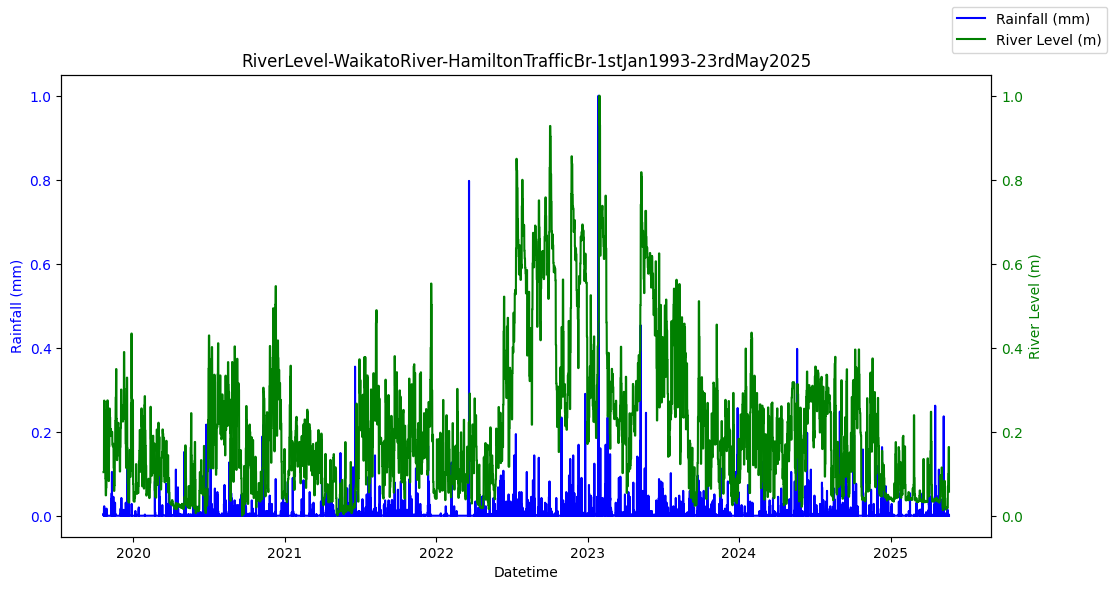

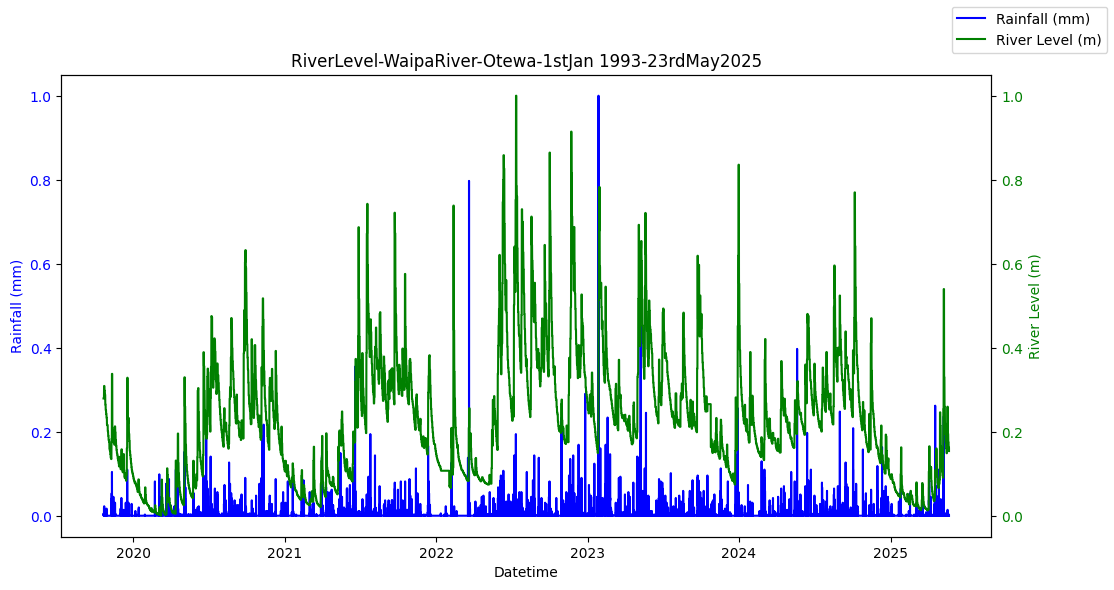

In [54]:
# Visualize
for key, df_merge in merged_data.items():
    X, y = generate_windowed_dataset(df_merge)
    visualize_merged_data(df_merge, title=key)

In [55]:
print(merged_data.keys())
merged_data['RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025']

dict_keys(['RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025', 'RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025'])


,datetime,rainfall_mm,wind_speed_mps,river_level
0,2019-10-21 01:00:00,0.002817,0.417062,0.279094
1,2019-10-21 02:00:00,0.000000,0.417062,0.279094
2,2019-10-21 03:00:00,0.000000,0.417062,0.279094
3,2019-10-21 04:00:00,0.000000,0.417062,0.279094
4,2019-10-21 05:00:00,0.000000,0.417062,0.279094
...,...,...,...,...
48845,2025-05-21 20:00:00,0.000000,0.023697,0.162204
48846,2025-05-21 21:00:00,0.000000,0.047393,0.162204
48847,2025-05-21 22:00:00,0.000000,0.023697,0.162204
48848,2025-05-21 23:00:00,0.000000,0.023697,0.162204


# QRU

Data shape: (365, 4)


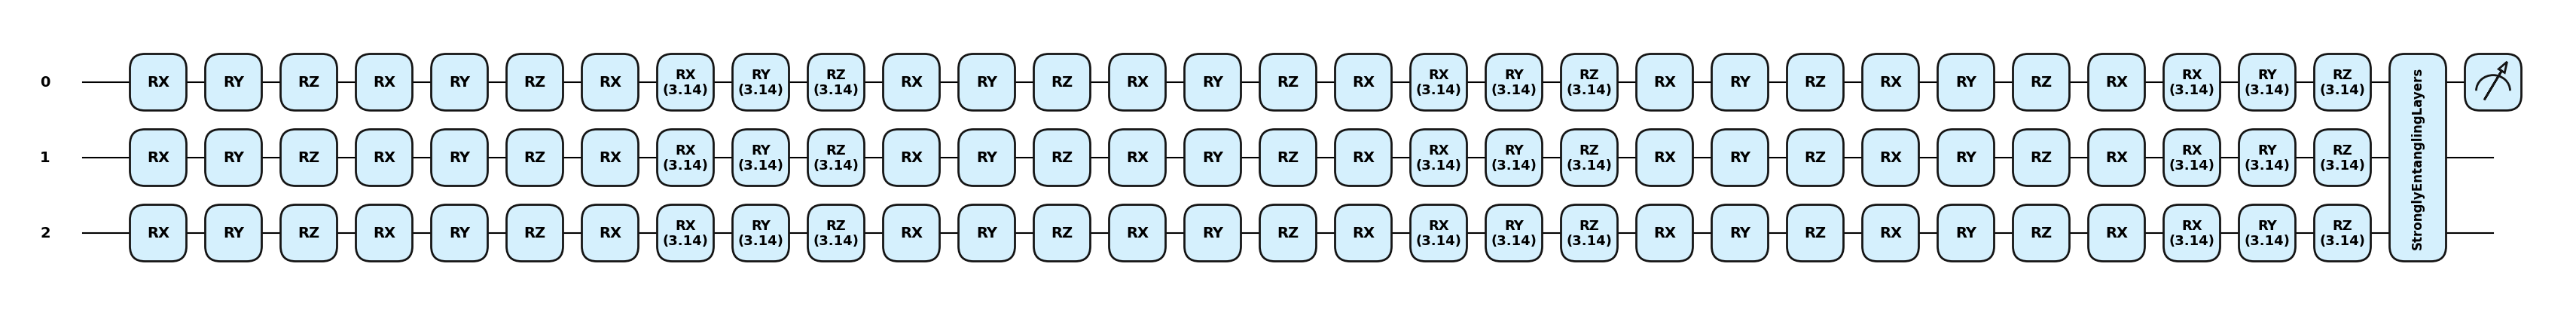

Trainable parameters: 99


Training QRU_ent:   3%|▎         | 8/300 [00:46<27:43,  5.70s/it]

In [ ]:
import random
import pandas as pd
import pennylane as qml
import numpy as np
import torch
import matplotlib.pyplot as plt
import csv
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

nb_reuploading = 3
lookback = 7  # window size
nb_qubit_reupload = 3

num_variational = 3
nb_epoch = 300
lr = 0.01
batch_size = 32

dev_reupload = qml.device("default.qubit", wires=nb_qubit_reupload, shots=None)

def encoding_layer(params_encoding, x, lookback, nb_qubit):        
    rotation_gates = [qml.RX, qml.RY, qml.RZ]
    for q in range(nb_qubit):
        for j in range(lookback):
            gate = rotation_gates[j % len(rotation_gates)]
            #target = j if j < nb_qubit else j % nb_qubit            
            gate(params_encoding[q,j] * x[:,j,q], wires=q)

def variational_layer(params_variational, lookback, nb_qubit, num_variational):    
    rotation_gates = [qml.RX, qml.RY, qml.RZ]
    for q in range(nb_qubit):
        for k in range(num_variational):
            gate = rotation_gates[k % len(rotation_gates)]                        
            gate(params_variational[q, k], wires=q)

@qml.qnode(dev_reupload, interface="torch", diff_method="backprop")
def quantum_circuit_reupload(x, params):
    params_enc, params_var, ent_wieghts = params        
    for i in range(nb_reuploading):
        encoding_layer(params_enc[i], x, lookback, nb_qubit_reupload)
        variational_layer(params_var[i], lookback, nb_qubit_reupload, num_variational)

    qml.StronglyEntanglingLayers(weights=ent_wieghts, wires=range(nb_qubit_reupload))    
    #return  [qml.expval(qml.PauliZ(i)) for i in range(nb_qubit_reupload)]
    return qml.expval(qml.PauliZ(0))

def prediction_accuracy(y_pred, y_true, tolerance=0.1):
    correct = torch.sum(torch.abs(y_pred - y_true) < tolerance)
    return 100 * correct / len(y_true)

def split_data(data, test_ratio, lookback, target_col):
    X, y = generate_windowed_dataset(data, lookback=lookback, target_col=target_col)
    split = int(len(X) * (1 - test_ratio))
    return X[:split], y[:split], X[split:], y[split:]

def plot_metrics(loss_hist, acc_hist, grad_norm_hist, name):
    epochs = range(1, len(loss_hist)+1)
    plt.figure()
    plt.plot(epochs, loss_hist, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{name}: Test Loss over Epochs")
    plt.legend()
    plt.savefig(f"{name}_loss_plot.png", dpi=300)
    plt.close()

    plt.figure()
    plt.plot(epochs, acc_hist, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{name}: Test Accuracy over Epochs")
    plt.legend()
    plt.savefig(f"{name}_accuracy_plot.png", dpi=300)
    plt.close()

    plt.figure()
    plt.plot(epochs, grad_norm_hist, label="Gradient Norm")
    plt.xlabel("Epochs")
    plt.ylabel("L2 Norm")
    plt.title(f"{name}: Gradient Norm over Epochs")
    plt.legend()
    plt.savefig(f"{name}_gradnorm_plot.png", dpi=300)
    plt.close()

def plot_predictions(y_true, y_pred, name):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label="Ground Truth", linewidth=2)
    plt.plot(y_pred, label="Predictions", linestyle="--")
    plt.xlabel("Index")
    plt.ylabel("Normalized Value")
    plt.title(f"{name}: Predictions vs Ground Truth")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{name}_prediction_plot.png", dpi=300)
    plt.close()

def train_and_eval(model, params_init, X_tr, y_tr, X_te, y_te, name, epochs, lr):
    params = [p.clone().detach().requires_grad_(True) for p in params_init]
    opt = torch.optim.RMSprop(params, lr=lr)
    loss_hist, acc_hist, grad_norm_hist = [], [], []
    param_count = sum(p.numel() for p in params if p.requires_grad)
    print(f"Trainable parameters: {param_count}")    
    mse_loss = torch.nn.MSELoss()
    train_ds = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=4)

    with open(f"{name}_metrics.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "test_loss", "test_acc", "grad_norm"])

        for ep in trange(epochs, desc=f"Training {name}"):
            for X_batch, y_batch in train_loader:
                opt.zero_grad()                
                preds = model(X_batch, params)
                #preds = torch.stack(preds) if isinstance(preds, list) else preds                
                loss = mse_loss(preds, y_batch)
                loss.backward()
                            
                total_norm = 0.0
                for p in params:
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                grad_norm = total_norm ** 0.5
                
                opt.step()

            with torch.no_grad():                   
                preds_t = model(X_te, params)
                loss_t = mse_loss(preds_t, y_te).item()
                acc_t = prediction_accuracy(preds_t, y_te).item()

            loss_hist.append(loss_t)
            acc_hist.append(acc_t)
            grad_norm_hist.append(grad_norm)

            writer.writerow([ep+1, loss_t, acc_t, grad_norm])
            f.flush()

    plot_metrics(loss_hist, acc_hist, grad_norm_hist, name)
    torch.save([p.detach() for p in params], f"{name}_trained_params.pt")

    with torch.no_grad():
        #preds_final = torch.stack([model(params, x) for x in X_te])
        preds_final = model(X_te, params)
        with open(f"{name}_predictions.csv", "w", newline="") as f_pred:
            writer = csv.writer(f_pred)
            writer.writerow(["Index", "Actual", "Predicted"])
            for i, (true_val, pred_val) in enumerate(zip(y_te, preds_final)):
                writer.writerow([i, true_val.item(), pred_val.item()])
        plot_predictions(y_te.numpy(), preds_final.numpy(), name)    

def draw_quantum_circuit():
    # Dummy input: [batch_size, lookback, nb_qubit] → use [1, lookback, nb_qubit] then squeeze to [lookback, nb_qubit]
    batch_size = 32
    dummy_x = torch.rand((batch_size, lookback, 3), dtype=torch.float64)

    # Dummy parameters with correct shape
    dummy_params = [
        torch.ones((nb_reuploading, nb_qubit_reupload, lookback), dtype=torch.float64) * np.pi,
        torch.ones((nb_reuploading, nb_qubit_reupload, num_variational), dtype=torch.float64) * np.pi,
        torch.ones(qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=nb_qubit_reupload), dtype=torch.float64) * np.pi
    ]

    # Draw the circuit    
    fig, ax = qml.draw_mpl(quantum_circuit_reupload, decimals=2, style="pennylane")(dummy_x, dummy_params)
    plt.show()

data = merged_data['RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025'].iloc[-365:].copy() # Due to limited compute - trainning on last one year of data 
print(f"Data shape: {data.shape}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
draw_quantum_circuit()
X_tr_np, y_tr_np, X_te_np, y_te_np = split_data(data=data, test_ratio=0.2, lookback=lookback, target_col='river_level')
X_tr = torch.tensor(X_tr_np, dtype=torch.float64).to(device)
y_tr = torch.tensor(y_tr_np, dtype=torch.float64).to(device)
X_te = torch.tensor(X_te_np, dtype=torch.float64).to(device)
y_te = torch.tensor(y_te_np, dtype=torch.float64).to(device)

ent_shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=nb_qubit_reupload)

params_init_reupload = [
    torch.full((nb_reuploading, nb_qubit_reupload, lookback), np.pi, dtype=torch.float64, requires_grad=True).to(device),
    torch.full((nb_reuploading, nb_qubit_reupload, num_variational), np.pi, dtype=torch.float64, requires_grad=True).to(device),
    torch.full((ent_shape), np.pi, dtype=torch.float64, requires_grad=True).to(device)
]

train_and_eval(quantum_circuit_reupload, params_init_reupload, X_tr, y_tr, X_te, y_te, "QRU_ent", nb_epoch, lr)

In [9]:
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

(torch.Size([39074, 7, 3]),
 torch.Size([39074]),
 torch.Size([9769, 7, 3]),
 torch.Size([9769]))

# QAOA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

# Define QUBO matrix based on risk scores and correlations (e.g., for premium allocation)
def define_qubo_matrix(risks, correlations, alpha=1.0, beta=0.5):
    """
    risks: list or np.array of individual region risks
    correlations: 2D array of pairwise correlations between regions
    alpha: risk weight
    beta: correlation penalty
    """
    n = len(risks)
    Q = np.zeros((n, n))

    for i in range(n):
        Q[i, i] = alpha * risks[i]
        for j in range(i + 1, n):
            Q[i, j] = beta * correlations[i, j]

    return Q

# Solve QUBO using D-Wave QPU (or hybrid solver)
def solve_qubo_qaoa(Q, num_reads=100):
    bqm = BinaryQuadraticModel.empty(vartype="BINARY")
    n = Q.shape[0]

    # Populate BQM
    for i in range(n):
        bqm.add_variable(i, Q[i, i])
        for j in range(i + 1, n):
            bqm.add_interaction(i, j, Q[i, j])

    sampler = EmbeddingComposite(DWaveSampler())
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    best = sampleset.first.sample
    energy = sampleset.first.energy
    print(f"Best solution: {best}, Energy: {energy:.4f}")
    return best, sampleset

# Visualize selected portfolio weights (1 = selected, 0 = not selected)
def visualize_portfolio_weights(solution_dict, region_labels=None):
    n = len(solution_dict)
    weights = [solution_dict[i] for i in range(n)]
    labels = region_labels if region_labels else [f"Region {i}" for i in range(n)]

    plt.figure(figsize=(10, 4))
    plt.bar(labels, weights, color="teal")
    plt.xticks(rotation=45, ha='right')
    plt.title("Optimized Insurance Portfolio Selection via QAOA")
    plt.ylabel("Selected (1) or Not (0)")
    plt.tight_layout()
    plt.show()

# Parametric Ins